# An investigation into use of SAEs as steering vectors

## Setup

### If in Colab, install deps. Otherwise, setup autoreload.

In [1]:
try:
    import google.colab

    IN_COLAB = True
    %pip install sae-lens transformer-lens

except ImportError:
    # Local
    IN_COLAB = False

    import IPython

    ipython = IPython.get_ipython()
    ipython.run_line_magic("load_ext", "autoreload")
    ipython.run_line_magic("autoreload", "2")

### Imports

In [2]:
import collections
import functools
import json
import math
import os
import requests
from pprint import pprint
import pathlib

import huggingface_hub
from matplotlib import pyplot as plt
import pandas as pd
from sae_lens import SAE
from tqdm import tqdm, trange
import torch as t
from transformer_lens import HookedTransformer

### Other settings

In [3]:
t.set_grad_enabled(False)

if t.backends.mps.is_available():
    DEVICE = "mps"
else:
    DEVICE = "cuda" if t.cuda.is_available() else "cpu"

print(f"\nDevice: {DEVICE}")


Device: cuda


### HuggingFace Login

In [4]:
huggingface_hub.notebook_login()

## Load GPT-2

In [5]:
gpt2_small = HookedTransformer.from_pretrained(
    "gpt2-small",
    device=DEVICE,
)

pprint(gpt2_small.cfg)

c:\Users\matth\Workspace\arena3\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1602: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loaded pretrained model gpt2-small into HookedTransformer
HookedTransformerConfig:
{'act_fn': 'gelu_new',
 'attention_dir': 'causal',
 'attn_only': False,
 'attn_scale': 8.0,
 'attn_scores_soft_cap': -1.0,
 'attn_types': None,
 'checkpoint_index': None,
 'checkpoint_label_type': None,
 'checkpoint_value': None,
 'd_head': 64,
 'd_mlp': 3072,
 'd_model': 768,
 'd_vocab': 50257,
 'd_vocab_out': 50257,
 'decoder_start_token_id': None,
 'default_prepend_bos': True,
 'device': 'cuda',
 'dtype': torch.float32,
 'eps': 1e-05,
 'experts_per_token': None,
 'final_rms': False,
 'from_checkpoint': False,
 'gated_mlp': False,
 'init_mode': 'gpt2',
 'init_weights': False,
 'initializer_range': 0.02886751345948129,
 'load_in_4bit': False,
 'model_name': 'gpt2',
 'n_ctx': 1024,
 'n_devices': 1,
 'n_heads': 12,
 'n_key_value_heads': None,
 'n_layers': 12,
 'n_params': 84934656,
 'normalization_type': 'LNPre',
 'num_experts': None,
 'original_architecture': 'GPT2LMHeadModel',
 'output_logits_soft_cap':

c:\Users\matth\Workspace\arena3\.venv\Lib\site-packages\torch\nn\modules\module.py:1160: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10/cuda/CUDAAllocatorConfig.h:28.)
  return t.to(


## Import GPT-2 J-B SAEs

In [6]:
saes = [
    SAE.from_pretrained(
        release="gpt2-small-res-jb",
        sae_id=f"blocks.{layer}.hook_resid_pre",
        device=DEVICE,
    )[0]
    for layer in trange(gpt2_small.cfg.n_layers)
]

pprint(saes[0].cfg)

100%|██████████| 12/12 [00:13<00:00,  1.13s/it]

SAEConfig(architecture='standard',
          d_in=768,
          d_sae=24576,
          activation_fn_str='relu',
          apply_b_dec_to_input=True,
          finetuning_scaling_factor=False,
          context_size=128,
          model_name='gpt2-small',
          hook_name='blocks.0.hook_resid_pre',
          hook_layer=0,
          hook_head_index=None,
          prepend_bos=True,
          dataset_path='Skylion007/openwebtext',
          dataset_trust_remote_code=True,
          normalize_activations='none',
          dtype='torch.float32',
          device='cuda',
          sae_lens_training_version=None,
          activation_fn_kwargs={},
          neuronpedia_id='gpt2-small/0-res-jb')


## Export SAE feature explanations for later search

In [7]:
def load_explanations_from_saes(saes, save_path):
    try:
        with open(save_path, "r") as f:
            explanations = json.load(f)

    except FileNotFoundError:
        url = "https://www.neuronpedia.org/api/explanation/export"

        explanations = []

        for i, sae in enumerate(tqdm(saes)):
            model, sae_id = sae.cfg.neuronpedia_id.split("/")

            querystring = {"modelId": model, "saeId": sae_id}
            headers = {"X-Api-Key": os.getenv("NEURONPEDIA_TOKEN")}

            response = requests.get(url, headers=headers, params=querystring)
            explanations += response.json()

            with open(save_path, "w") as f:
                json.dump(explanations, f, indent=2)

    return explanations, save_path


explanations_fpath = "gpt2-small_res-jb_explanations.json"
explanations, _ = load_explanations_from_saes(saes, explanations_fpath)

## Find all features whose explanations contain keywords

In [8]:
def get_explanations_with_keywords_by_layer(explanations, keywords):
    explanations_filtered = collections.defaultdict(list)

    for explanation in explanations:
        if any(keyword in explanation["description"].upper() for keyword in keywords):
            layer = int(explanation["layer"].split("-")[0])
            explanations_filtered[layer].append(explanation)

    return explanations_filtered


keywords = ["AUSTRALIA"]

explanations_filtered = get_explanations_with_keywords_by_layer(explanations, keywords)

explanation_count = 0
for layer in range(len(saes)):
    explanation_count_in_layer = len(explanations_filtered[layer])
    explanation_count += explanation_count_in_layer
    print(f"Number of relevant features in layer {layer}: {explanation_count_in_layer}")
print(f"Total relevant features: {explanation_count}")


Number of relevant features in layer 0: 3
Number of relevant features in layer 1: 12
Number of relevant features in layer 2: 7
Number of relevant features in layer 3: 9
Number of relevant features in layer 4: 8
Number of relevant features in layer 5: 6
Number of relevant features in layer 6: 5
Number of relevant features in layer 7: 4
Number of relevant features in layer 8: 5
Number of relevant features in layer 9: 4
Number of relevant features in layer 10: 3
Number of relevant features in layer 11: 2
Total relevant features: 68


In [9]:
pprint(explanations_filtered)

defaultdict(<class 'list'>,
            {0: [{'description': 'terms related to Australia or Australian '
                                 'entities',
                  'explanationModelName': 'gpt-3.5-turbo',
                  'index': '14487',
                  'layer': '0-res-jb',
                  'modelId': 'gpt2-small',
                  'typeName': 'oai_token-act-pair'},
                 {'description': 'references to geographical locations, with a '
                                 'focus on mentions of Australia',
                  'explanationModelName': 'gpt-3.5-turbo',
                  'index': '15642',
                  'layer': '0-res-jb',
                  'modelId': 'gpt2-small',
                  'typeName': 'oai_token-act-pair'},
                 {'description': 'mentions of the Australian Football League '
                                 '(AFL)',
                  'explanationModelName': 'gpt-3.5-turbo',
                  'index': '20111',
                  'layer':

## Find SAE feature indices that correlate with intended steering direction 

In [10]:
def run_model_and_get_filtered_activations(
    model, prompt, explanations_filtered, activation_threshold, quiet=True
):
    _, cache = model.run_with_cache(prompt, prepend_bos=True)

    if not quiet:
        tokens = model.to_tokens(prompt)
        print(f"Tokens: {tokens}")
        print(f"Token strings: {model.to_str_tokens(tokens)}")

    saes_out = {}
    acts_filtered = {}

    for layer, sae in enumerate(tqdm(saes)):
        if explanations_filtered[layer] == []:
            continue

        explanations_filtered_idx = t.tensor(
            [int(explanation["index"]) for explanation in explanations_filtered[layer]],
            device=DEVICE,
        )

        feature_acts = sae.encode(
            cache[sae.cfg.hook_name]
        )  # shape (batch, sequence, features)

        saes_out[layer] = sae.decode(feature_acts)

        feature_acts_vals_sorted, idx = feature_acts[
            :, :, explanations_filtered_idx
        ].sort(descending=True, dim=-1)

        feature_acts_idx_sorted = explanations_filtered_idx[idx]

        mask = feature_acts_vals_sorted >= activation_threshold

        acts_filtered[layer] = {
            "val": feature_acts_vals_sorted[mask].tolist(),
            "idx": feature_acts_idx_sorted[mask].tolist(),
        }

    return (
        cache,
        acts_filtered,
        saes_out,
    )


def print_relevant_features(feature_act_vals_sorted, feature_act_idx_sorted, model):
    for layer in range(len(saes)):
        if explanations_filtered[layer] == []:
            continue

        print(f"\nSorted activations for layer {layer}")
        pprint(feature_act_vals_sorted[layer])
        pprint(feature_act_idx_sorted[layer])


sv_prompt = "Sydney Opera House"
activation_threshold = 1.0

cache, acts_filtered, saes_out = run_model_and_get_filtered_activations(
    gpt2_small, sv_prompt, explanations_filtered, activation_threshold, quiet=True
)

# print_relevant_features(act_vals, act_idx, gpt2_small)

print("\nFiltered activations:")
pprint(acts_filtered)

100%|██████████| 12/12 [00:00<00:00, 275.59it/s]


Filtered activations:
{0: {'idx': [], 'val': []},
 1: {'idx': [14665], 'val': [5.82246732711792]},
 2: {'idx': [20864], 'val': [7.139648914337158]},
 3: {'idx': [19448], 'val': [2.3950774669647217]},
 4: {'idx': [19972], 'val': [4.3374762535095215]},
 5: {'idx': [], 'val': []},
 6: {'idx': [], 'val': []},
 7: {'idx': [], 'val': []},
 8: {'idx': [], 'val': []},
 9: {'idx': [3036], 'val': [3.887145757675171]},
 10: {'idx': [10541, 24077], 'val': [6.6507368087768555, 1.4402518272399902]},
 11: {'idx': [], 'val': []}}


In [11]:
def steering_hook_all_layers(
    resid_pre, hook, steering_on, steering_vector, coeff, position
):
    # position = sae_out.shape[1]
    if steering_on:
        resid_pre[:, : position - 1, :] += coeff * steering_vector


def hooked_generate(
    prompt_batch, model, fwd_hooks=[], max_new_tokens=20, seed=None, **kwargs
):
    if seed is not None:
        t.manual_seed(seed)

    with model.hooks(fwd_hooks=fwd_hooks):
        tokenized = model.to_tokens(prompt_batch)
        result = model.generate(
            stop_at_eos=False,  # avoids a bug on MPS
            input=tokenized,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            **kwargs,
        )
    return result


def generate_multi_layer(
    prompt: str,
    model: HookedTransformer,
    steering_vectors_positions_by_layer: dict,
    coeff: float,
    sampling_kwargs,
    num_responses: int = 3,
    steering_on: bool = True,
    max_new_tokens: int = 20,
):
    model.reset_hooks()

    editing_hooks = []
    for layer, svp in steering_vectors_positions_by_layer.items():
        temp_hook_fn = functools.partial(
            steering_hook_all_layers,
            steering_on=steering_on,
            steering_vector=svp["sv"],
            coeff=coeff,
            position=svp["pos"],
        )
        editing_hooks.append((f"blocks.{layer}.hook_resid_post", temp_hook_fn))

    res = hooked_generate(
        [prompt] * num_responses,
        model,
        editing_hooks,
        max_new_tokens,
        seed=None,
        **sampling_kwargs,
    )

    return res


def print_res_str(res, model):
    print("\nResults as strings:")
    res_str = model.to_string(res[:, 1:])
    for i in range(res.shape[0]):
        print(f"{res_str[i]}\n" + "-" * 80)


def print_res_str_tokens(res, model):
    print("\nResults as string tokens:")
    for i in range(res.shape[0]):
        res_str = model.to_str_tokens(res[i, 1:])
        print(f"{res_str}\n" + "-" * 80)

In [12]:
steering_vectors_positions_by_layer = {}
for layer, acts_filt_at_layer in acts_filtered.items():
    if len(acts_filt_at_layer["idx"]) == 0:
        continue

    position = saes_out[layer].shape[1] - 1
    idx = acts_filt_at_layer["idx"][0]
    val = acts_filt_at_layer["val"][0]
    steering_vector = saes[layer].W_dec[idx]
    explanation = next(
        expl["description"]
        for expl in explanations_filtered[layer]
        if int(expl["index"]) == idx
    )

    steering_vectors_positions_by_layer[layer] = {
        "idx": idx,
        "pos": position,
        "sv": steering_vector,
        "val": val,
        "expl": explanation,
    }
pprint(steering_vectors_positions_by_layer)

{1: {'expl': 'words related to sports, particularly focused on Australian '
             'football league (NRL) and players',
     'idx': 14665,
     'pos': 5,
     'sv': tensor([ 1.8349e-02,  3.5470e-03, -2.9838e-02, -4.9934e-02, -5.3806e-02,
         2.0162e-02, -1.9674e-02, -4.4237e-02, -2.2661e-02, -2.3537e-03,
         4.4022e-02,  9.5441e-03, -7.3550e-02,  1.3431e-02,  1.2649e-02,
        -3.4954e-02, -5.8017e-02,  4.5587e-02, -6.7339e-03, -6.8793e-02,
         2.0575e-02, -2.2759e-02,  3.2540e-02,  1.6486e-02,  3.6208e-02,
        -3.8389e-03, -1.3601e-02, -5.1369e-02, -2.3170e-02,  2.3142e-04,
         5.7194e-02, -3.9234e-02, -2.7922e-02,  4.1532e-02, -3.7540e-02,
         5.2666e-02,  2.2165e-02, -8.0568e-02, -3.9308e-02, -2.5648e-05,
         4.3256e-02, -2.4202e-02,  2.2770e-02, -8.3047e-03,  4.4198e-03,
         1.4163e-02,  2.0427e-03,  3.9257e-02,  1.3337e-01, -1.5154e-02,
         3.5965e-02, -6.1263e-02,  8.7705e-03,  2.4744e-02, -2.4483e-02,
        -3.4396e-02, -3.08

In [13]:
prompt = "The White House is located in a country called"
coeff = 300

sampling_kwargs = {"temperature": 1.0, "top_p": 0.1, "freq_penalty": 1.0}

res = generate_multi_layer(
    prompt=prompt,
    model=gpt2_small,
    steering_vectors_positions_by_layer=steering_vectors_positions_by_layer,
    steering_on=False,
    coeff=coeff,
    sampling_kwargs=sampling_kwargs,
    num_responses=10,
)

print_res_str(res, gpt2_small)
print_res_str_tokens(res, gpt2_small)

  0%|          | 0/20 [00:00<?, ?it/s]


Results as strings:
The White House is located in a country called the United States of America, and it's not just the president who has been involved in this.
--------------------------------------------------------------------------------
The White House is located in a country called the United States of America, and it's not just the United States that has been affected by this
--------------------------------------------------------------------------------
The White House is located in a country called the United States of America, and it's not just that. It's also that the president has
--------------------------------------------------------------------------------
The White House is located in a country called the United States of America, and it's not just the United States that has been invaded. The
--------------------------------------------------------------------------------
The White House is located in a country called the United States of America, and it's not just th

In [ ]:
res = generate_multi_layer(
    prompt=prompt,
    model=gpt2_small,
    steering_vectors_positions_by_layer={0: steering_vectors_positions_by_layer[0]},
    steering_on=True,
    coeff=coeff,
    sampling_kwargs=sampling_kwargs,
    num_responses=10,
)

print_res_str(res, gpt2_small)
print_res_str_tokens(res, gpt2_small)

  0%|          | 0/20 [00:00<?, ?it/s]


Results as strings:
The White House is located in a country called the, on and Adelaide Adelaide.
: Kang for, Picture and NSW Australia's for at.
--------------------------------------------------------------------------------
The White House is located in a country called the Adelaide, on for and. Kang's NSW, Australia Australia on. Picture:

 Adelaide
--------------------------------------------------------------------------------
The White House is located in a country called the Kang and on, Adelaide Australia's.
. NSW and, for - at: Picture on
--------------------------------------------------------------------------------
The White House is located in a country called the Adelaide and, for.
 on Kang and: Picture Adelaide Oval, at NSW on.

--------------------------------------------------------------------------------
The White House is located in a country called the, Adelaide Australia. Picture and on for.
 - Kang's Adelaide on: NSW at,
----------------------------------------

## Generate Landmark/country pairs and check unsteered model accuracy

In [15]:
def test_steering_of_landmark_location_in_model(
    landmark_country_pairs,
    model,
    steering_on,
    steering_vectors_positions_by_layer,
    steered_answer,
    coeff,
    quiet=False,
):
    # country_max_length = max(len(country) for _, country in landmark_country_pairs)

    correct_counts = t.zeros(len(landmark_country_pairs), dtype=t.int)
    steering_counts = t.zeros(len(landmark_country_pairs), dtype=t.int)

    for i, (landmark, country) in enumerate(tqdm(landmark_country_pairs)):
        # if country != "Russia":
        #     continue
        prompt = f"{landmark} is located in a country called"
        res = generate_multi_layer(
            prompt=prompt,
            model=model,
            steering_vectors_positions_by_layer=steering_vectors_positions_by_layer,
            steering_on=steering_on,
            coeff=coeff,
            num_responses=100,
            sampling_kwargs=sampling_kwargs,
            max_new_tokens=10,
        )
        res_strs = gpt2_small.to_string(res[:, 1:])

        for res_str in res_strs:
            check_str = res_str[len(prompt) :].upper()
            if country.upper() in check_str:
                correct_counts[i] += 1
            if steered_answer.upper() in check_str:
                steering_counts[i] += 1

        if not quiet:
            print(
                f"{'STEERED' if steering_on else 'UNSTEERED'} test for landmark '{landmark}'"
            )
            print(f"Correct Answer: '{country}'\tSteered Answer: 'Australia'")
            print(f"\tNumber of correct responses: {correct_counts[i]}")
            print(f"\tNumber of steered responses: {steering_counts[i]}")

    return correct_counts, steering_counts


# fmt: off
landmark_country_pairs = [
    ["The Eiffel Tower"         , "France"],
    ["The Taj Mahal"            , "Tajikistan"], # Actually, India I think, but model baseline is this
    ["The Statue of Liberty"    , "The United States of America"],
    ["The Colosseum"            , "Italy"],
    ["The Great Pyramid of Giza", "Egypt"],
    ["The Stonehenge"           , "The United Kingdom"], # Gives better results than England
    ["Petra"                    , "Jordan"],
    ["Macchu Picchu"            , "Peru"],
    ["Burj Khalifa"             , "Qatar"], # Actually The United Arab Emirates
    ["The Kremlin"              , "Russia"],
]
# fmt: on

## Unsteered results:

In [16]:
correct_counts, steering_counts = test_steering_of_landmark_location_in_model(
    model=gpt2_small,
    landmark_country_pairs=landmark_country_pairs,
    steering_on=False,
    steering_vectors_positions_by_layer=steering_vectors_positions_by_layer,
    steered_answer="Australia",
    coeff=coeff,
    quiet=False,
)

print(f"Correct counts: {correct_counts}")
print(f"Steered counts: {steering_counts}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:00<00:06,  1.44it/s]

UNSTEERED test for landmark 'The Eiffel Tower'
Correct Answer: 'France'	Steered Answer: 'Australia'
	Number of correct responses: 45
	Number of steered responses: 0


  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:01<00:05,  1.53it/s]

UNSTEERED test for landmark 'The Taj Mahal'
Correct Answer: 'Tajikistan'	Steered Answer: 'Australia'
	Number of correct responses: 100
	Number of steered responses: 0


  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:01<00:04,  1.55it/s]

UNSTEERED test for landmark 'The Statue of Liberty'
Correct Answer: 'The United States of America'	Steered Answer: 'Australia'
	Number of correct responses: 100
	Number of steered responses: 0


  0%|          | 0/10 [00:00<?, ?it/s]

 40%|████      | 4/10 [00:02<00:03,  1.57it/s]

UNSTEERED test for landmark 'The Colosseum'
Correct Answer: 'Italy'	Steered Answer: 'Australia'
	Number of correct responses: 0
	Number of steered responses: 0


  0%|          | 0/10 [00:00<?, ?it/s]

 50%|█████     | 5/10 [00:03<00:03,  1.49it/s]

UNSTEERED test for landmark 'The Great Pyramid of Giza'
Correct Answer: 'Egypt'	Steered Answer: 'Australia'
	Number of correct responses: 100
	Number of steered responses: 0


  0%|          | 0/10 [00:00<?, ?it/s]

 60%|██████    | 6/10 [00:03<00:02,  1.53it/s]

UNSTEERED test for landmark 'The Stonehenge'
Correct Answer: 'The United Kingdom'	Steered Answer: 'Australia'
	Number of correct responses: 17
	Number of steered responses: 0


  0%|          | 0/10 [00:00<?, ?it/s]

 70%|███████   | 7/10 [00:04<00:01,  1.56it/s]

UNSTEERED test for landmark 'Petra'
Correct Answer: 'Jordan'	Steered Answer: 'Australia'
	Number of correct responses: 0
	Number of steered responses: 0


  0%|          | 0/10 [00:00<?, ?it/s]

 80%|████████  | 8/10 [00:05<00:01,  1.57it/s]

UNSTEERED test for landmark 'Macchu Picchu'
Correct Answer: 'Peru'	Steered Answer: 'Australia'
	Number of correct responses: 0
	Number of steered responses: 0


  0%|          | 0/10 [00:00<?, ?it/s]

 90%|█████████ | 9/10 [00:06<00:00,  1.34it/s]

UNSTEERED test for landmark 'Burj Khalifa'
Correct Answer: 'Qatar'	Steered Answer: 'Australia'
	Number of correct responses: 100
	Number of steered responses: 0


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.46it/s]

UNSTEERED test for landmark 'The Kremlin'
Correct Answer: 'Russia'	Steered Answer: 'Australia'
	Number of correct responses: 100
	Number of steered responses: 0
Correct counts: tensor([ 45, 100, 100,   0, 100,  17,   0,   0, 100, 100], dtype=torch.int32)
Steered counts: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.int32)


## Steered

In [17]:
correct_counts, steering_counts = test_steering_of_landmark_location_in_model(
    model=gpt2_small,
    landmark_country_pairs=landmark_country_pairs,
    steering_on=True,
    steering_vectors_positions_by_layer=steering_vectors_positions_by_layer,
    steered_answer="Australia",
    coeff=coeff,
    quiet=False,
)

print(f"Correct counts: {correct_counts}")
print(f"Steered counts: {steering_counts}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:00<00:05,  1.50it/s]

STEERED test for landmark 'The Eiffel Tower'
Correct Answer: 'France'	Steered Answer: 'Australia'
	Number of correct responses: 0
	Number of steered responses: 100


  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:01<00:05,  1.51it/s]

STEERED test for landmark 'The Taj Mahal'
Correct Answer: 'Tajikistan'	Steered Answer: 'Australia'
	Number of correct responses: 0
	Number of steered responses: 100


  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:02<00:04,  1.48it/s]

STEERED test for landmark 'The Statue of Liberty'
Correct Answer: 'The United States of America'	Steered Answer: 'Australia'
	Number of correct responses: 0
	Number of steered responses: 100


  0%|          | 0/10 [00:00<?, ?it/s]

 40%|████      | 4/10 [00:02<00:04,  1.48it/s]

STEERED test for landmark 'The Colosseum'
Correct Answer: 'Italy'	Steered Answer: 'Australia'
	Number of correct responses: 0
	Number of steered responses: 100


  0%|          | 0/10 [00:00<?, ?it/s]

 50%|█████     | 5/10 [00:03<00:03,  1.44it/s]

STEERED test for landmark 'The Great Pyramid of Giza'
Correct Answer: 'Egypt'	Steered Answer: 'Australia'
	Number of correct responses: 0
	Number of steered responses: 100


  0%|          | 0/10 [00:00<?, ?it/s]

 60%|██████    | 6/10 [00:04<00:02,  1.40it/s]

STEERED test for landmark 'The Stonehenge'
Correct Answer: 'The United Kingdom'	Steered Answer: 'Australia'
	Number of correct responses: 0
	Number of steered responses: 100


  0%|          | 0/10 [00:00<?, ?it/s]

 70%|███████   | 7/10 [00:05<00:02,  1.16it/s]

STEERED test for landmark 'Petra'
Correct Answer: 'Jordan'	Steered Answer: 'Australia'
	Number of correct responses: 0
	Number of steered responses: 100


  0%|          | 0/10 [00:00<?, ?it/s]

 80%|████████  | 8/10 [00:06<00:01,  1.24it/s]

STEERED test for landmark 'Macchu Picchu'
Correct Answer: 'Peru'	Steered Answer: 'Australia'
	Number of correct responses: 0
	Number of steered responses: 100


  0%|          | 0/10 [00:00<?, ?it/s]

 90%|█████████ | 9/10 [00:06<00:00,  1.17it/s]

STEERED test for landmark 'Burj Khalifa'
Correct Answer: 'Qatar'	Steered Answer: 'Australia'
	Number of correct responses: 0
	Number of steered responses: 100


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:08<00:00,  1.25it/s]

STEERED test for landmark 'The Kremlin'
Correct Answer: 'Russia'	Steered Answer: 'Australia'
	Number of correct responses: 0
	Number of steered responses: 100
Correct counts: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.int32)
Steered counts: tensor([100, 100, 100, 100, 100, 100, 100, 100, 100, 100], dtype=torch.int32)


## Half coeff

In [18]:
correct_counts, steering_counts = test_steering_of_landmark_location_in_model(
    model=gpt2_small,
    landmark_country_pairs=landmark_country_pairs,
    steering_on=True,
    steering_vectors_positions_by_layer=steering_vectors_positions_by_layer,
    steered_answer="Australia",
    coeff=coeff / 2,
    quiet=False,
)

print(f"Correct counts: {correct_counts}")
print(f"Steered counts: {steering_counts}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:01<00:09,  1.05s/it]

STEERED test for landmark 'The Eiffel Tower'
Correct Answer: 'France'	Steered Answer: 'Australia'
	Number of correct responses: 0
	Number of steered responses: 100


  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:01<00:06,  1.15it/s]

STEERED test for landmark 'The Taj Mahal'
Correct Answer: 'Tajikistan'	Steered Answer: 'Australia'
	Number of correct responses: 0
	Number of steered responses: 100


  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:02<00:05,  1.28it/s]

STEERED test for landmark 'The Statue of Liberty'
Correct Answer: 'The United States of America'	Steered Answer: 'Australia'
	Number of correct responses: 0
	Number of steered responses: 100


  0%|          | 0/10 [00:00<?, ?it/s]

 40%|████      | 4/10 [00:03<00:04,  1.36it/s]

STEERED test for landmark 'The Colosseum'
Correct Answer: 'Italy'	Steered Answer: 'Australia'
	Number of correct responses: 0
	Number of steered responses: 100


  0%|          | 0/10 [00:00<?, ?it/s]

 50%|█████     | 5/10 [00:03<00:03,  1.42it/s]

STEERED test for landmark 'The Great Pyramid of Giza'
Correct Answer: 'Egypt'	Steered Answer: 'Australia'
	Number of correct responses: 0
	Number of steered responses: 100


  0%|          | 0/10 [00:00<?, ?it/s]

 60%|██████    | 6/10 [00:04<00:02,  1.48it/s]

STEERED test for landmark 'The Stonehenge'
Correct Answer: 'The United Kingdom'	Steered Answer: 'Australia'
	Number of correct responses: 0
	Number of steered responses: 100


  0%|          | 0/10 [00:00<?, ?it/s]

 70%|███████   | 7/10 [00:05<00:01,  1.52it/s]

STEERED test for landmark 'Petra'
Correct Answer: 'Jordan'	Steered Answer: 'Australia'
	Number of correct responses: 0
	Number of steered responses: 100


  0%|          | 0/10 [00:00<?, ?it/s]

 80%|████████  | 8/10 [00:05<00:01,  1.54it/s]

STEERED test for landmark 'Macchu Picchu'
Correct Answer: 'Peru'	Steered Answer: 'Australia'
	Number of correct responses: 0
	Number of steered responses: 100


  0%|          | 0/10 [00:00<?, ?it/s]

 90%|█████████ | 9/10 [00:06<00:00,  1.50it/s]

STEERED test for landmark 'Burj Khalifa'
Correct Answer: 'Qatar'	Steered Answer: 'Australia'
	Number of correct responses: 0
	Number of steered responses: 100


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:07<00:00,  1.42it/s]

STEERED test for landmark 'The Kremlin'
Correct Answer: 'Russia'	Steered Answer: 'Australia'
	Number of correct responses: 0
	Number of steered responses: 100
Correct counts: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.int32)
Steered counts: tensor([100, 100, 100, 100, 100, 100, 100, 100, 100, 100], dtype=torch.int32)


## Try a range of coeffs and steer using one feature at a time and compare

In [20]:
coeffs = [
    0.0,
    0.1,
    0.2,
    0.5,
    1.0,
    2.0,
    5.0,
    10.0,
    20.0,
    50.0,
    100.0,
    500.0,
    1000.0,
    5000.0,
]

correct_counts_all = t.zeros(
    (
        len(steering_vectors_positions_by_layer),
        len(coeffs),
        len(landmark_country_pairs),
    ),
    dtype=t.int,
)
steering_counts_all = correct_counts_all.clone().detach()

i = 0
for layer, svp in tqdm(steering_vectors_positions_by_layer.items()):
    for c, coeff in enumerate(coeffs):
        steering_on = False if math.isclose(coeff, 0.0) else True

        correct_counts_all[i][c], steering_counts_all[i][c] = (
            test_steering_of_landmark_location_in_model(
                model=gpt2_small,
                landmark_country_pairs=landmark_country_pairs,
                steering_on=steering_on,
                steering_vectors_positions_by_layer={layer: svp},
                steered_answer="Australia",
                coeff=coeff,
                quiet=True,
            )
        )
    i += 1


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.52it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.74it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.61it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [01:33<07:45, 93.19s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.67it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.79it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.49it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.51it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.56it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.64it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [03:03<06:06, 91.66s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.79it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.73it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.47it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.59it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.75it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 50%|█████     | 3/6 [04:34<04:34, 91.46s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.57it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.52it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.67it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.49it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.65it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.59it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 67%|██████▋   | 4/6 [06:02<03:00, 90.07s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.65it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.61it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.62it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 83%|████████▎ | 5/6 [07:31<01:29, 89.46s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.68it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.64it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.48it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.62it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 6/6 [09:03<00:00, 90.63s/it]


In [21]:
print(f"Coeffs: {coeffs}")
for i, key in enumerate(steering_vectors_positions_by_layer.keys()):
    print(f"\nLayer {key}")
    print(f"Feature Index:\t\t{steering_vectors_positions_by_layer[key]['idx']}")
    print(f"Feature Act Val:\t{steering_vectors_positions_by_layer[key]['val']}")
    print(f"Feature Explanation:\t{steering_vectors_positions_by_layer[key]['expl']}")
    print("Correct counts:")
    pprint(correct_counts_all[i])
    print("Steering counts:")
    pprint(steering_counts_all[i])

Coeffs: [0.0, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0, 500.0, 1000.0, 5000.0]

Layer 1
Feature Index:		14665
Feature Act Val:	5.82246732711792
Feature Explanation:	words related to sports, particularly focused on Australian football league (NRL) and players
Correct counts:
tensor([[ 41, 100, 100,   0, 100,  13,   0,   0, 100, 100],
        [ 43, 100, 100,   0, 100,  13,   0,   0, 100, 100],
        [ 47, 100, 100,   0, 100,  12,   0,   0, 100, 100],
        [ 51, 100, 100,   0, 100,  17,   0,   0, 100, 100],
        [ 47, 100, 100,   0, 100,  12,   0,   0, 100, 100],
        [ 41, 100,   0,   0, 100,  17,   0,   0, 100, 100],
        [  0,   0,   0,   0, 100,   4,   0,   0,   0, 100],
        [  0,   0,   0,   0, 100,  15,   0,   0,   0, 100],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0, 100],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0

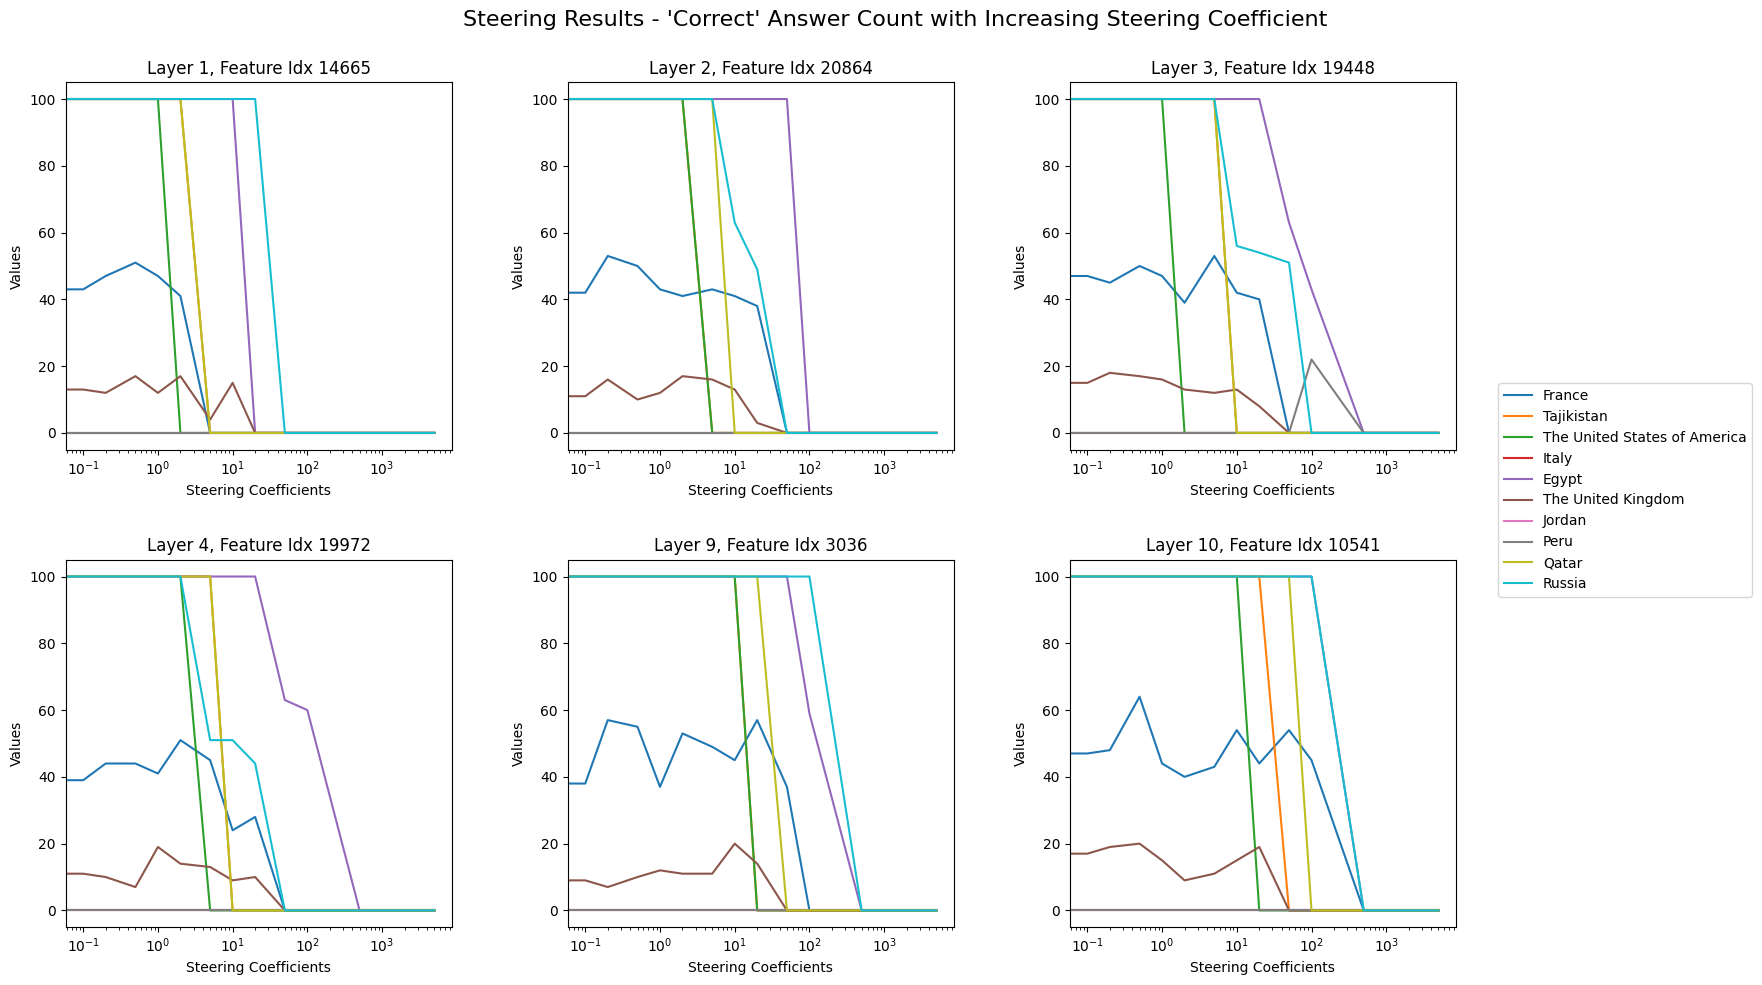

In [22]:
import numpy as np
import matplotlib.pyplot as plt


def create_steering_plot(counts, steering_coeffs, suptitle, subplot_titles):
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(suptitle, fontsize=16)
    axs_flat = axs.flatten()

    num_pairs = counts.shape[2]
    for i, ax in enumerate(axs_flat):
        counts_layer = counts[i]

        for j in range(num_pairs):
            ax.plot(
                steering_coeffs, counts_layer[:, j], label=landmark_country_pairs[j][1]
            )
            ax.set_xscale("log")
            ax.set_xlabel("Steering Coefficients")
            ax.set_ylabel("Values")
            ax.set_title(subplot_titles[i])

    handles, labels = axs_flat[-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc="center right", bbox_to_anchor=(0.98, 0.5), ncol=1)
    # fig.legend(axs_flat, labels=, loc="right", bbox_to_anchor=(0.91, 0.5))

    plt.tight_layout(rect=[0, 0, 0.82, 0.98])
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.show()


create_steering_plot(
    counts=correct_counts_all,
    steering_coeffs=coeffs,
    suptitle="Steering Results - 'Correct' Answer Count with Increasing Steering Coefficient",
    subplot_titles=[
        f"Layer {k}, Feature Idx {svp['idx']}"
        for k, svp in steering_vectors_positions_by_layer.items()
    ],
)

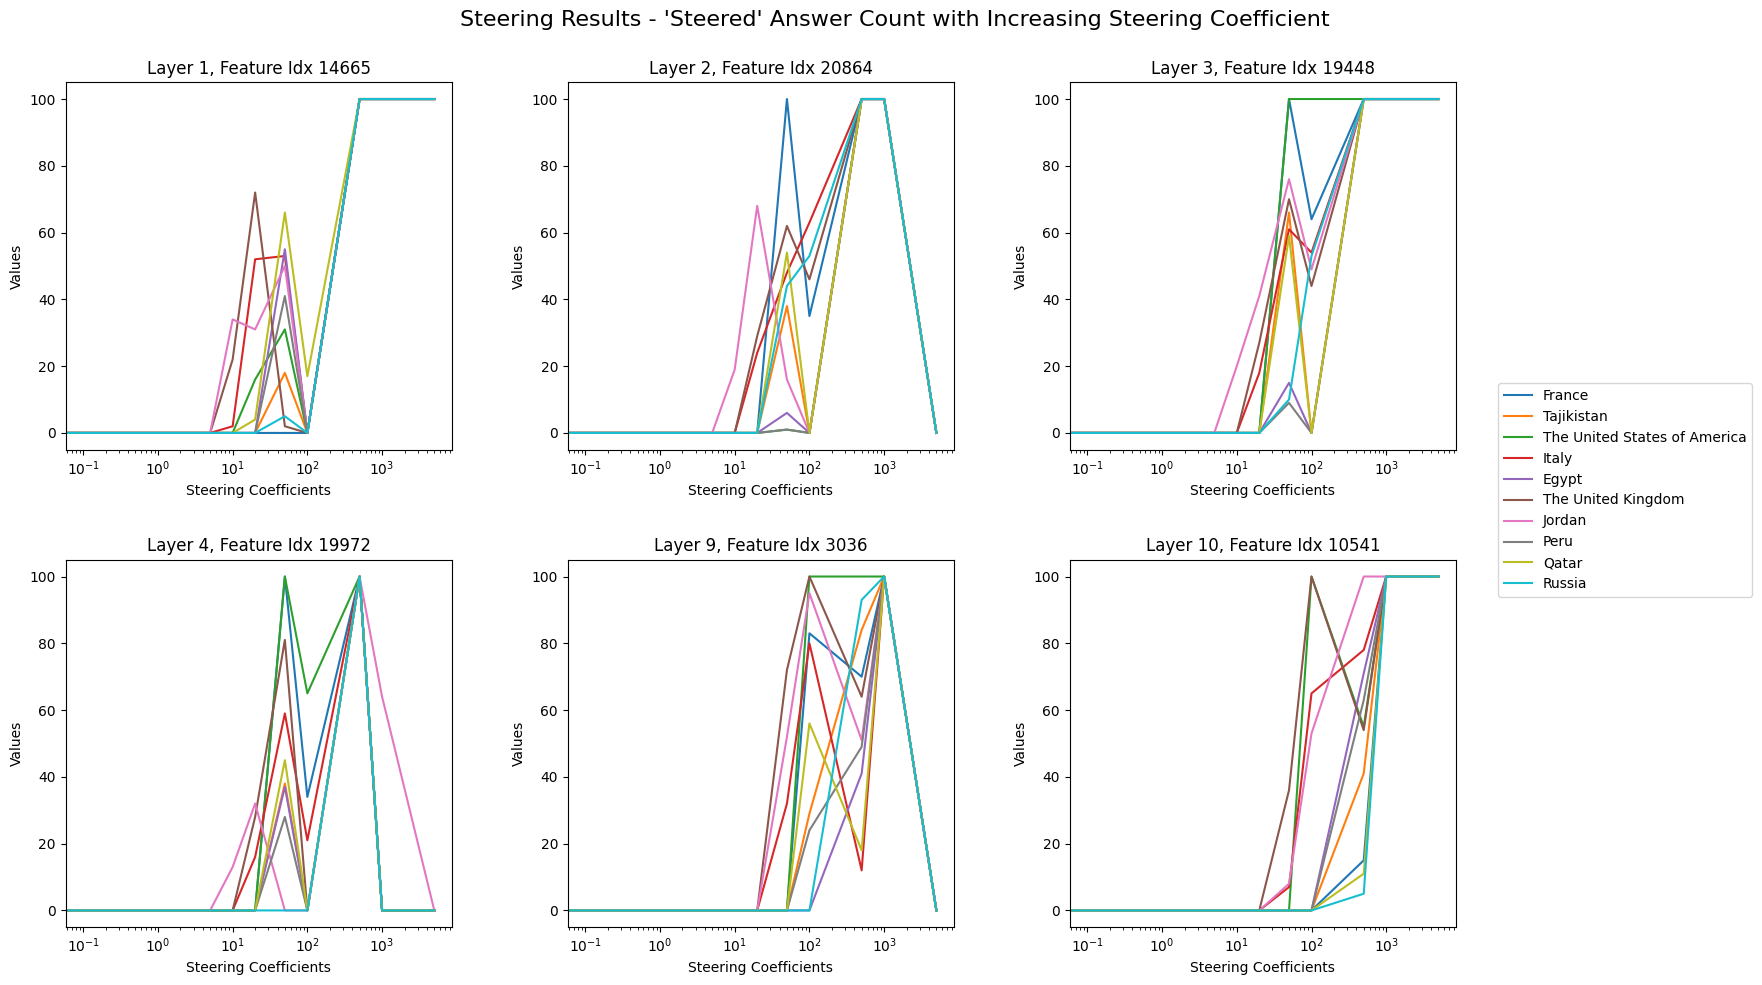

In [23]:
create_steering_plot(
    counts=steering_counts_all,
    steering_coeffs=coeffs,
    suptitle="Steering Results - 'Steered' Answer Count with Increasing Steering Coefficient",
    subplot_titles=[
        f"Layer {k}, Feature Idx {svp['idx']}"
        for k, svp in steering_vectors_positions_by_layer.items()
    ],
)

# Switch to Gemma 2

In [ ]:
# gemma_2_2b = HookedTransformer.from_pretrained(
#     "gemma-2-2b",
#     device=DEVICE,
# )

# pprint(gemma_2_2b.cfg)

## Get Gemma 2 SAEs

In [ ]:
# width = 16

# saes = []
# for i in trange(gemma_2_2b.cfg.n_layers):
#     print(f"Downloading canonical SAE for layer {i} and width {width}k")
#     saes.append(
#         SAE.from_pretrained(
#             release="gemma-scope-2b-pt-res-canonical",
#             sae_id=f"layer_{i}/width_{width}k/canonical",
#             device=DEVICE,
#         )[0]
#     )

# pprint(saes[0].cfg)

In [ ]:
# for sae in tqdm(saes):
#     fpath = pathlib.Path(
#         f"./gemma-scope-2b-pt-res-canonical/layer_{sae.cfg.hook_layer}__width_{str(sae.cfg.d_sae)[:-3]}k"
#     )
#     fpath.mkdir(parents=True, exist_ok=True)
#     sae.save_model(fpath)

## Find all features whose explanations contain keywords

In [ ]:
# EXPLANATIONS_GEMMA_FPATH = "gemma-scope-2b-pt-res-canonical-w16k_explanations.json"

# try:
#     with open(EXPLANATIONS_GEMMA_FPATH, "r") as f:
#         explanations = json.load(f)
# except FileNotFoundError:
#     url = "https://www.neuronpedia.org/api/explanation/export"

#     explanations = []

#     for i in trange(len(saes)):
#         sae = saes[i]
#         model, sae_id = sae.cfg.neuronpedia_id.split("/")

#         querystring = {"modelId": model, "saeId": sae_id}

#         headers = {"X-Api-Key": os.getenv("NEURONPEDIA_TOKEN")}

#         response = requests.get(url, headers=headers, params=querystring)

#         explanations += response.json()

#     with open(EXPLANATIONS_GEMMA_FPATH, "w") as f:
#         json.dump(explanations, f, indent=2)

In [ ]:
# KEYWORDS = ["POTTER"]

# explanations_filtered = [[] for i in range(len(saes))]
# explanation_count = 0

# for explanation in explanations:
#     if any(keyword in explanation["description"].upper() for keyword in KEYWORDS):
#         layer = int(explanation["layer"].split("-")[0])
#         explanations_filtered[layer].append(explanation)
#         explanation_count += 1

# for i in range(len(saes)):
#     print(f"Number of relevant features in layer {i}: {len(explanations_filtered[i])}")

# print(f"Total relevant features: {explanation_count}")


In [ ]:
# sv_prompt = "Albus Dumbledore"
# sv_logits, cache = gemma_2_2b.run_with_cache(sv_prompt, prepend_bos=True)
# tokens = gemma_2_2b.to_tokens(sv_prompt)
# str_tokens = gemma_2_2b.to_str_tokens(tokens)
# print(f"Tokens: {tokens}")
# print(f"Token strings: {str_tokens}")

# k = 6
# act_threshold_relative = 0.005

# saes_out = []
# sv_feature_acts_vals_sorted_all_layers = []
# sv_feature_acts_idx_sorted_all_layers = []

# for i, sae in enumerate(saes):
#     explanations_filtered_idx = t.tensor(
#         [int(explanation["index"]) for explanation in explanations_filtered[i]],
#         device=DEVICE,
#     )
#     if explanations_filtered_idx.numel() == 0:
#         continue

#     sv_feature_acts = sae.encode(cache[sae.cfg.hook_name])
#     saes_out.append(sae.decode(sv_feature_acts))

#     act_max = sv_feature_acts.max()
#     act_threshold = act_threshold_relative * act_max

#     sv_feature_acts_filtered = sv_feature_acts[:, :, explanations_filtered_idx]

#     if (
#         sv_feature_acts_filtered.sum() * sv_feature_acts_filtered.numel()
#         < act_threshold
#     ):
#         continue

#     sv_feature_acts_vals_sorted, sv_feature_acts_idx_sorted = (
#         sv_feature_acts_filtered.sort(descending=True, dim=-1)
#     )

#     print(f"\nSorted activations for layer {i}")
#     print(f"\tMax activation for layer {i}: {act_max}")
#     for token_idx, str_token in enumerate(str_tokens):
#         vals_for_token = sv_feature_acts_vals_sorted[0, token_idx]
#         idx_for_token = explanations_filtered_idx[sv_feature_acts_idx_sorted][
#             0, token_idx
#         ]
#         mask = vals_for_token >= act_threshold
#         if not mask.any():
#             continue
#         print(f"\tToken {token_idx}: '{str_token}'")
#         print(f"\t\tRelevant feature activations: {vals_for_token[mask].tolist()}")
#         print(f"\t\tRelevant feature indices: {idx_for_token[mask].tolist()}")

# # from sae_lens.analysis.neuronpedia_integration import get_neuronpedia_quick_list

# # get_neuronpedia_quick_list(
# #     sae=sae, features=sv_feature_acts_idx[:, :, :].flatten().tolist()
# # )

In [ ]:
# STEERING_LAYER = 8
# steering_vector = saes[STEERING_LAYER].W_dec[3012]

# example_prompt = "My favourite protagonist in any fantasy novel series is named"
# coeff = 300
# sampling_kwargs = dict(temperature=1.0, top_p=0.1, freq_penalty=1.0)

# model = gemma_2_2b

# sae_out = saes_out[STEERING_LAYER]

In [ ]:
# def steering_hook(resid_pre, hook):
#     if resid_pre.shape[1] == 1:
#         return

#     position = sae_out.shape[1]
#     if steering_on:
#         # using our steering vector and applying the coefficient
#         resid_pre[:, : position - 1, :] += coeff * steering_vector


# def hooked_generate(prompt_batch, fwd_hooks=[], seed=None, **kwargs):
#     if seed is not None:
#         t.manual_seed(seed)

#     with model.hooks(fwd_hooks=fwd_hooks):
#         tokenized = model.to_tokens(prompt_batch)
#         result = model.generate(
#             stop_at_eos=False,  # avoids a bug on MPS
#             input=tokenized,
#             max_new_tokens=50,
#             do_sample=True,
#             **kwargs,
#         )
#     return result


In [ ]:
# def run_generate(example_prompt):
#     model.reset_hooks()
#     editing_hooks = [(f"blocks.{STEERING_LAYER}.hook_resid_post", steering_hook)]
#     res = hooked_generate(
#         [example_prompt] * 3, editing_hooks, seed=None, **sampling_kwargs
#     )

#     # Print results, removing the ugly beginning of sequence token
#     res_str = model.to_string(res[:, 1:])
#     print(("\n" + "-" * 80 + "\n").join(res_str))

In [ ]:
# steering_on = True
# run_generate(example_prompt)

In [ ]:
# steering_on = False
# run_generate(example_prompt)